<a href="https://colab.research.google.com/github/nelyasi71/ObjectLocalization/blob/main/ObjectLocalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python


  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-_36lr8e7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-_36lr8e7
  Resolved https://github.com/albumentations-team/albumentations to commit 12f5801973b6a93aeb04199c169dd661cbd7304d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-many

Download Dataset

In [2]:
!git clone https://github.com/parth1620/object-localization-dataset.git


Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 5.60 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import torch
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')


In [5]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'
NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


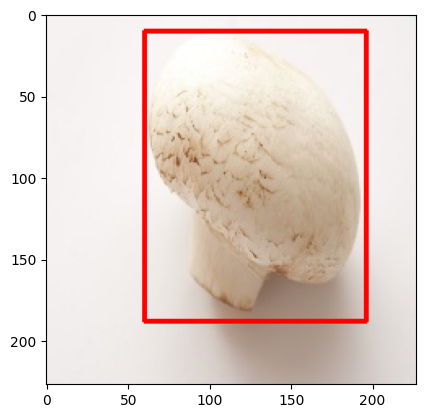

In [10]:
row = df.iloc[random.randint(0, 185)]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1 = (row.xmin,row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2,(255,0,0),2)
plt.imshow(bnd_box_img)

In [11]:
train_df,valid_df = train_test_split(df,test_size=0.20,random_state=42)

## Augmentations

In [12]:
import albumentations as A

In [13]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


## Create Custom Dataset

In [14]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin,ymin,xmax,ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img,bboxes = bbox,class_labels = [None])
      img= data['image']
      bbox = data ['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1)/255.0
    bbox = torch.Tensor(bbox)

    return img,bbox

In [15]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df,valid_augs)

In [16]:
print("Total examples in the trainset:",len(trainset))
print("Total examples in the validset:",len(validset))

Total examples in the trainset: 148
Total examples in the validset: 38


## Load dataset into batches

In [17]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE,shuffle = True)
validloader = torch.utils.data.DataLoader(validset,batch_size = BATCH_SIZE,shuffle = False)


In [18]:
print("Total no. batches in trainloader:",len(trainloader))
print("Total no. batches in validloader:",len(validloader))

Total no. batches in trainloader: 10
Total no. batches in validloader: 3


In [19]:
for images ,bboxes in trainloader:
  break;

print("shape of one batch images:",images.shape)
print("shape of one batch bboxes:",bboxes.shape)

shape of one batch images: torch.Size([16, 3, 140, 140])
shape of one batch bboxes: torch.Size([16, 4])


## Create Model

In [20]:
from torch import nn
import timm

In [21]:
class ObjLocModel(nn.Module):

    def __init__(self):
      super(ObjLocModel,self).__init__()
      self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes = 4)

    def forward(self,images,gt_bboxes = None):

      bboxes = self.backbone(images)

      if gt_bboxes != None:
        loss = nn.MSELoss()(bboxes,gt_bboxes)
        return bboxes,loss
      return bboxes

In [22]:
model = ObjLocModel()
model.to(DEVICE);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [23]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

## Create train and eval functions

In [24]:
def train_fn(model,dataloader,optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):

    images,gt_bboxes = data
    images,gt_bboxes = images.to(DEVICE),gt_bboxes.to(DEVICE)

    bboxes,loss = model(images,gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [25]:
def eval_fn(model,dataloader):
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(dataloader):

      images,gt_bboxes = data
      images,gt_bboxes = images.to(DEVICE),gt_bboxes.to(DEVICE)

      bboxes,loss = model(images,gt_bboxes)

      total_loss += loss.item()
    return total_loss / len(dataloader)

## Training Loop

In [26]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model,trainloader,optimizer)
  valid_loss = eval_fn(model,validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("WEIGHTS-ARE-SAVED")
    best_valid_loss = valid_loss
  print(f"Epoch:{i+1}train loss: {train_loss}valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:1train loss: 5344.0474609375valid loss: 6702.062174479167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:2train loss: 2056.87431640625valid loss: 1055.5183512369792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:3train loss: 1163.3047973632813valid loss: 220.59178670247397


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:4train loss: 795.3865478515625valid loss: 206.22157287597656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:5train loss: 601.9412811279296valid loss: 215.33818562825522


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:6train loss: 443.4534454345703valid loss: 222.26815795898438


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:7train loss: 372.21624450683595valid loss: 238.24410502115884


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:8train loss: 248.625valid loss: 205.39374287923178


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:9train loss: 189.60907516479492valid loss: 242.98367818196616


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:10train loss: 144.83777618408203valid loss: 211.40970865885416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:11train loss: 128.59024200439453valid loss: 123.05737050374348


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:12train loss: 112.61468887329102valid loss: 134.89928181966147


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:13train loss: 98.7662368774414valid loss: 115.90649922688802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:14train loss: 114.35392913818359valid loss: 139.0960439046224


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:15train loss: 92.14797897338867valid loss: 121.8702163696289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:16train loss: 88.34555397033691valid loss: 138.049196879069


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:17train loss: 86.0056167602539valid loss: 107.72842915852864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:18train loss: 82.9074550628662valid loss: 86.25192515055339


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:19train loss: 79.57447776794433valid loss: 116.23445383707683


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:20train loss: 74.9157958984375valid loss: 111.64390563964844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:21train loss: 78.50093460083008valid loss: 69.4564692179362


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:22train loss: 68.29386749267579valid loss: 59.36578369140625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:23train loss: 55.424200248718265valid loss: 85.54775873819987


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:24train loss: 73.80141639709473valid loss: 104.17122141520183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:25train loss: 55.03341999053955valid loss: 74.49867630004883


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:26train loss: 64.44396171569824valid loss: 70.79780832926433


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:27train loss: 68.14221878051758valid loss: 111.15428415934245


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:28train loss: 54.574432373046875valid loss: 73.45748138427734


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:29train loss: 49.574418449401854valid loss: 61.2059580485026


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch:30train loss: 47.86332416534424valid loss: 55.031838734944664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:31train loss: 50.57929000854492valid loss: 82.45596822102864


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:32train loss: 57.640397262573245valid loss: 79.81485366821289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:33train loss: 61.07896957397461valid loss: 95.70041147867839


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:34train loss: 36.461978340148924valid loss: 71.04258728027344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:35train loss: 43.98919506072998valid loss: 79.61705271402995


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:36train loss: 39.10982189178467valid loss: 65.32336934407552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:37train loss: 50.32066135406494valid loss: 75.27342987060547


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:38train loss: 46.10532016754151valid loss: 64.6819839477539


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:39train loss: 43.68765525817871valid loss: 75.37023417154948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:40train loss: 65.3024070739746valid loss: 76.84195963541667


## Inference

In [28]:
import utils

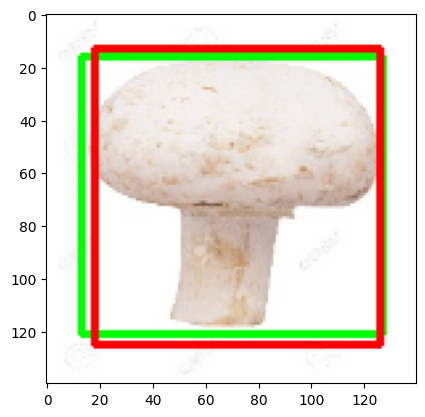

In [29]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
  image,gt_bbox = validset[1]
  image = image.unsqueeze(0).to(DEVICE)
  out_bbox = model(image)
  predicted_label = out_bbox.cpu().numpy()
  true_label = gt_bbox.cpu().numpy()


  true_labels.append(true_label)
  predicted_labels.append(predicted_label)

  utils.compare_plots(image,gt_bbox,out_bbox)

